In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.rec.reconstruction as rec
import algotom
import algotom.prep.calculation as calc
import h5py as h5f
import timeit
from joblib import Parallel, delayed
from skimage.measure import profile_line
import ast

In [2]:
# %matplotlib notebook
%matplotlib inline

# Workflow starts here!

In [7]:
###################### need to change start
ipts="19458"
###################### need to change end

In [8]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(hdf5_loc)

['ct_scans_half.h5']

In [10]:
###################### need to change start
sample_name = "ct_scans_half"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [11]:
losa.get_hdf_tree(hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (1801,)
    │   ├── ang_rad (1801,)
    │   ├── fname (1801,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (2048, 590)
    │   ├── ob_fake (2048, 590)
    │   ├── proj_mlog_to_recon (1801, 2048, 590)
    │   └── proj_norm (1801, 2048, 590)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 590)
    │   ├── fluc_corr_roi_min (1680, 75)
    │   ├── ob_min (2048, 590)
    │   ├── proj_crop_roi_min (2048, 590)
    │   └── proj_min (2048, 590)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (2048, 200, 200)
    └── sino
        │
        ├── sino_mlog_to_recon (2048, 1801, 590)
        └── sino_norm (2048, 1801, 590)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (1801,)',
       '    │   ├── ang_rad (1801,)',
       '    │   ├── fname (1801,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (2048, 590)',
       '    │   ├── ob_fake (2048, 590)',
       '    │   ├── proj_mlog_to_recon (1801, 2048, 590)',
       '    │   └── proj_norm (1801, 2048, 590)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (2048, 590)',
       '    │   ├── fluc_corr_roi_min (1680, 75)',
       '    │   ├── ob_min (2048, 590)',
       '    │   ├── proj_crop_roi_min (2048, 590)',
       '    │   └── proj_min (2048, 590)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (2048, 200, 200)',
       '    └── sino',
       '        │',
       '     

In [12]:
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
rot_center = history_dict['rot_center']
if 'recon_crop_roi' in history_dict.keys():
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None
history_dict

{'crop': False,
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 80, 'top': 20, 'bottom': 1700},
 'minus_log': True,
 'tilt_corr_roi': {'left': 10, 'right': 500, 'top': 50, 'bottom': 2000},
 'tilt_corr': -0.7256422310429781,
 'ring_removal': 'bm3d',
 'rot_center': 277.43043518066406,
 'recon_algo': 'gridrec',
 'pixel_size_um': 37,
 'recon_crop': True,
 'recon_crop_roi': {'left': 250, 'right': 450, 'top': 150, 'bottom': 350}}

/tmp/ipykernel_39137/3912605048.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


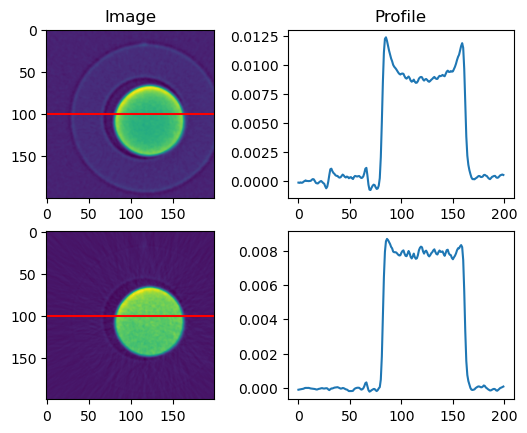

In [18]:
###################### need to change start
idx = 500
bh_q = 0.2
bh_n = 10
line_loc = 100
###################### need to change end
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
sino_mlog_to_recon_bh_corr = corr.beam_hardening_correction(mat=sino_mlog_to_recon[idx], q=bh_q, n=bh_n)
rec_img_bh_corr = rec.gridrec_reconstruction(sino_mlog_to_recon_bh_corr, rot_center, angles=ang_rad, apply_log=False)
rec_img_bh_corr = rocku.crop(rec_img_bh_corr, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
start = (line_loc, 0)
end = (line_loc, rec_img.shape[1]-1)
profile = profile_line(rec_img, start, end)
profile_bh_corr = profile_line(rec_img_bh_corr, start, end)
fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('Image')
ax[0][0].imshow(rec_img)
ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[0][1].set_title('Profile')
ax[0][1].plot(profile)
# ax[1][0].set_title('Image_BH')
ax[1][0].imshow(rec_img_bh_corr)
ax[1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
# ax[1][1].set_title('Profile_BH')
ax[1][1].plot(profile_bh_corr)
fig.show()

# Reconstruction

In [18]:
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name + "_BH"
pix_um = history_dict['pixel_size_um']
pix_cm = pix_um/10000
t0 = timeit.default_timer()
recon_algo = 'gridrec'
for h_idx in range(sino_mlog_to_recon.shape[0]):
    _sino_mlog_to_recon_bh_corr = corr.beam_hardening_correction(mat=sino_mlog_to_recon[h_idx], q=bh_q, n=bh_n)
    _rec_slice = rec.gridrec_reconstruction(_sino_mlog_to_recon_bh_corr, rot_center, angles=ang_rad, apply_log=False)
    _rec_slice = rocku.crop(_rec_slice, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    _rec_slice_cm = _rec_slice/pix_cm
    _slice_name = save_to + "/recon_" + f'{h_idx:04d}'
    print('Saving {} ...'.format(_slice_name))
    dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
# history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00000 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00001 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00002 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00003 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00004 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00005 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00006 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00007 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00008 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00009 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00010 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00095 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00096 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00097 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00098 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00099 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00100 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00101 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00102 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00103 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00104 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00105 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00190 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00191 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00192 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00193 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00194 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00195 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00196 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00197 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00198 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00199 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00200 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00285 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00286 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00287 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00288 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00289 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00290 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00291 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00292 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00293 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00294 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00295 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00380 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00381 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00382 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00383 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00384 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00385 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00386 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00387 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00388 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00389 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00390 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00475 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00476 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00477 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00478 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00479 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00480 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00481 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00482 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00483 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00484 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00485 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00570 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00571 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00572 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00573 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00574 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00575 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00576 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00577 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00578 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00579 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00580 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00665 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00666 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00667 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00668 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00669 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00670 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00671 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00672 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00673 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00674 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00675 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00760 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00761 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00762 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00763 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00764 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00765 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00766 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00767 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00768 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00769 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00770 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00855 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00856 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00857 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00858 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00859 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00860 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00861 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00862 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00863 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00864 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00865 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00950 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00951 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00952 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00953 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00954 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00955 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00956 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00957 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00958 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00959 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_00960 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01045 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01046 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01047 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01048 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01049 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01050 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01051 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01052 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01053 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01054 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01055 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01140 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01141 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01142 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01143 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01144 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01145 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01146 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01147 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01148 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01149 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01150 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01235 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01236 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01237 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01238 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01239 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01240 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01241 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01242 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01243 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01244 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01245 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01330 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01331 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01332 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01333 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01334 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01335 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01336 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01337 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01338 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01339 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01340 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01425 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01426 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01427 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01428 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01429 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01430 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01431 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01432 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01433 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01434 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01435 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01520 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01521 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01522 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01523 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01524 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01525 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01526 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01527 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01528 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01529 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01530 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01615 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01616 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01617 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01618 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01619 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01620 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01621 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01622 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01623 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01624 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01625 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01710 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01711 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01712 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01713 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01714 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01715 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01716 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01717 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01718 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01719 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01720 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01805 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01806 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01807 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01808 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01809 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01810 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01811 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01812 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01813 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01814 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01815 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01900 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01901 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01902 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01903 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01904 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01905 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01906 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01907 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01908 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01909 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01910 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored

Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01995 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01996 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01997 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01998 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_01999 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02000 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02001 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02002 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02003 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02004 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autoreduce/rockit/ct_scans_half_BH/recon_02005 ...
Saving /HFIR/CG1D/IPTS-19458/shared/autored